<a href="https://colab.research.google.com/github/sriharsha2024/DCGAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
import os
from glob import glob
import seaborn as sns
from keras import layers
from time import perf_counter 
import os

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
train_image='/content/gdrive/MyDrive/gan/images/'
tile_df = pd.read_csv(os.path.join(train_image, '/content/gdrive/MyDrive/gan/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'))
tile_df.head()

,imgid,type
0,ISIC_0000000,benign
1,ISIC_0000001,benign
2,ISIC_0000002,malignant
3,ISIC_0000004,malignant
4,ISIC_0000006,benign


In [ ]:
import shutil
import sys

labels = pd.read_csv(r'/content/gdrive/MyDrive/gan/ISBI2016_ISIC_Part3_Training_GroundTruth.csv')
train_path= train_image 
test_path='/content/gdrive/MyDrive/gan/ISBI2016_ISIC_Part3_Test_Data/'
t_labels=pd.read_csv(r'/content/gdrive/MyDrive/gan/ISBI2016_ISIC_Part3_Test_GroundTruth.csv')

# Tr=test_path+ '//'
# Dr = train_image+ '/'
# if not os.path.exists(Tr):
#     os.mkdir(Tr)

# for filename, class_name in t_labels.values:
#     if not os.path.exists (Tr+ '/' +  str(class_name)):
#         os.mkdir(Tr+ '/' +  str(class_name))
#     src_path =test_path + filename +'.jpg'
#     dst_path= Tr+ '/' +  str(class_name) 
#     shutil.copy(src_path, dst_path)
# print("sucessful")


# if not os.path.exists(Dr):
#     os.mkdir(Dr)
    
# for filename, class_name in labels.values:
#     if not os.path.exists (Dr+ '/' +  str(class_name)):
#         os.mkdir(Dr+ '/' +  str(class_name))
#     src_path =train_path + filename +'.jpg'
#     dst_path= Dr+ '/' +  str(class_name) 
#     shutil.copy(src_path, dst_path)
# print("sucessful")

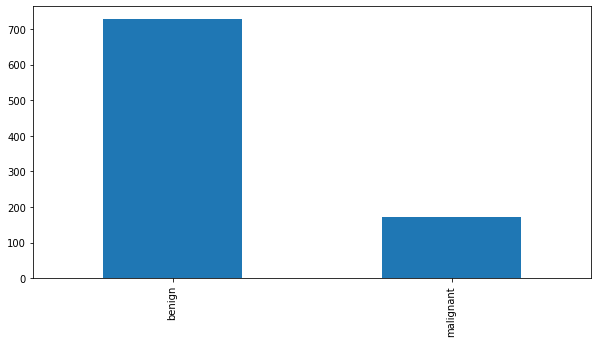

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
tile_df.describe(exclude=[np.number])

,imgid,type
count,900,900
unique,900,2
top,ISIC_0000000,benign
freq,1,727


In [ ]:
from keras.layers import Dense,Reshape,Flatten,Conv2D,MaxPool2D,Dropout,Conv2DTranspose,BatchNormalization,LeakyReLU 
from keras.models import Sequential

In [ ]:
batch_size=8

In [ ]:
from keras.preprocessing import image

In [ ]:
discriminator= Sequential()

discriminator.add(Conv2D(64,kernel_size=5,strides=2,padding="same",activation='relu',input_shape=[360,800,3]))
discriminator.add(Dropout(0.5))

discriminator.add(Conv2D(128,kernel_size=5,strides=2,padding="same",activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())

discriminator.add(Dense(1,activation='sigmoid'))



In [ ]:
coding_size=100
generator=Sequential()
generator.add(Dense(90*200*128,activation='relu',use_bias=False,input_shape=[100]))
generator.add(Reshape([90,200,128]))
generator.add(BatchNormalization())


generator.add(Conv2DTranspose(64,kernel_size=5,strides=2,padding="same",activation='relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(3,kernel_size=5,strides=2,padding="same", activation='tanh'))


In [ ]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2304000)           230400000 
                                                                 
 reshape (Reshape)           (None, 90, 200, 128)      0         
                                                                 
 batch_normalization (BatchN  (None, 90, 200, 128)     512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 180, 400, 64)     204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 180, 400, 64)     256       
 hNormalization)                                                 
                                                      

In [ ]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 400, 64)      4864      
                                                                 
 dropout (Dropout)           (None, 180, 400, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 200, 128)      204928    
                                                                 
 dropout_1 (Dropout)         (None, 90, 200, 128)      0         
                                                                 
 flatten (Flatten)           (None, 2304000)           0         
                                                                 
 dense (Dense)               (None, 1)                 2304001   
                                                                 
Total params: 2,513,793
Trainable params: 2,513,793
Non-

In [ ]:
GAN=Sequential([generator,discriminator])
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 360, 800, 3)       230610435 
                                                                 
 sequential (Sequential)     (None, 1)                 2513793   
                                                                 
Total params: 233,124,228
Trainable params: 233,123,844
Non-trainable params: 384
_________________________________________________________________


In [ ]:
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable=False

In [ ]:
GAN.compile(loss='binary_crossentropy',optimizer='adam')

In [ ]:
def process_img(img_path):
  img=tf.io.read_file(img_path)
  img=tf.image.decode_jpeg(img)
  img=tf.image.resize(img,[360,800])
  return img

dataset=tf.data.Dataset.list_files('/content/gdrive/MyDrive/gan/images/malignant/*').map(process_img).map(lambda x:x/255)
dataset=dataset.batch(batch_size,drop_remainder=True)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
generator, discriminator =GAN.layers
epochs=25

for epoch in range(epochs):
    print(f"Currently on epoch {epoch+1}")
    i=0
    
    for X_batch in dataset:
        i=i+1

        #discriminator train
        noise=tf.random.normal(shape=[batch_size,100])
        
        gen_image=generator(noise)

        X_fake_vs_real = tf.concat([gen_image,tf.dtypes.cast(X_batch,tf.float32)],axis=0)
  
        y1 = tf.constant([[0.0]]*batch_size +[[1.0]]*batch_size)
        
        discriminator.trainable=True
        
        discriminator.train_on_batch(X_fake_vs_real,y1)
        #generator train
        noise= tf.random.normal(shape=[batch_size, coding_size])
        y2=tf.constant([[1.0]]*batch_size)
        discriminator.trainable=False
        GAN.train_on_batch(noise,y2)
        
        

Currently on epoch 1
Currently on epoch 2
Currently on epoch 3
Currently on epoch 4
Currently on epoch 5
Currently on epoch 6
Currently on epoch 7
Currently on epoch 8
Currently on epoch 9
Currently on epoch 10
Currently on epoch 11
Currently on epoch 12
Currently on epoch 13
Currently on epoch 14
Currently on epoch 15
Currently on epoch 16
Currently on epoch 17
Currently on epoch 18
Currently on epoch 19
Currently on epoch 20
Currently on epoch 21
Currently on epoch 22
Currently on epoch 23
Currently on epoch 24
Currently on epoch 25


In [ ]:
noise=tf.random.normal(shape=[batch_size,100])
gen_image=generator(noise)
gen_image.shape

In [ ]:
n=tf.random.normal(shape=[10,100])

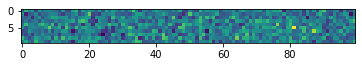

In [ ]:
plt.imshow(n)

In [ ]:
images=generator(n)

In [ ]:
images.shape

TensorShape([10, 360, 800, 3])

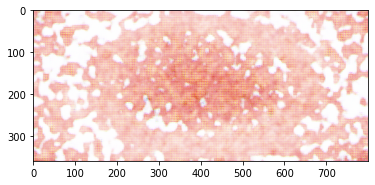

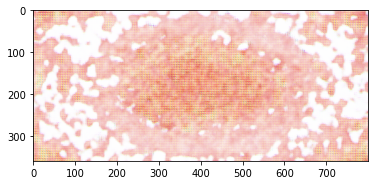

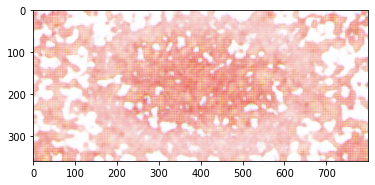

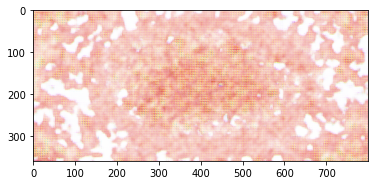

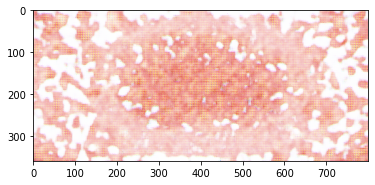

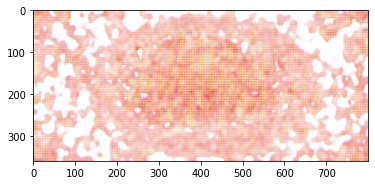

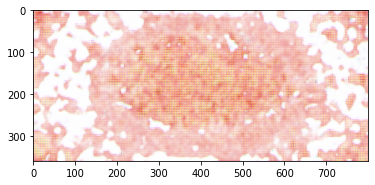

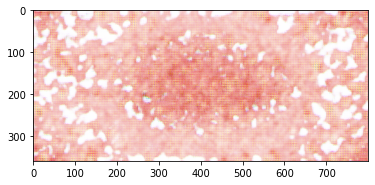

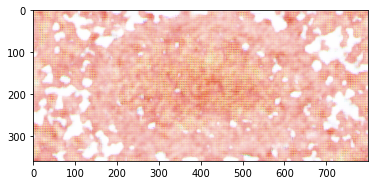

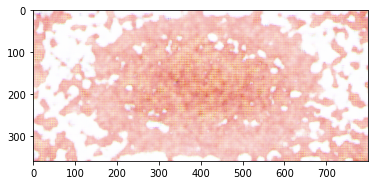

In [ ]:
for image in images:
  plt.imshow(image.numpy())
  plt.show()

## **classification** **model**

In [ ]:
model =Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=[360, 800, 3],activation='relu'))
model.add(MaxPool2D(pool_size=(5,5)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 358, 798, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 71, 159, 32)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 69, 157, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 34, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 76, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 38, 64)      

In [ ]:
from keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
image_gen=ImageDataGenerator(rescale=1/255,shear_range=0.1)
train_image_gen = image_gen.flow_from_directory('/content/gdrive/MyDrive/gan/images/',target_size=[360, 800],color_mode='rgb',batch_size=16,class_mode='binary')

Found 900 images belonging to 2 classes.


In [ ]:
# test_image_gen = image_gen.flow_from_directory(test_path,target_size=im_shape[:2],shuffle=TRUE,color_mode='rgb',batch_size=16)

In [ ]:
results=model.fit_generator(train_image_gen,epochs=2,callbacks=[early_stop])

<ipython-input-35-6c1f2ea62a87>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results=model.fit_generator(train_image_gen,epochs=2,callbacks=[early_stop])


Epoch 1/2
57/57 [==============================] - ETA: 0s - loss: 0.5280 - accuracy: 0.8011

57/57 [==============================] - 448s 8s/step - loss: 0.5280 - accuracy: 0.8011
Epoch 2/2
57/57 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.8089

57/57 [==============================] - 95s 2s/step - loss: 0.5026 - accuracy: 0.8089


In [ ]:
# pred=model.predict_generator(test_image_gen)

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
train_image_gen.class_indices

{'benign': 0, 'malignant': 1}

In [ ]:
# confusion_matrix(test_image_gen.classes, predictions)

In [ ]:
model.predict(images)

1/1 [==============================] - 1s 722ms/step


array([[0.12325802],
       [0.06631456],
       [0.13117702],
       [0.09475228],
       [0.11892794],
       [0.08368346],
       [0.09010195],
       [0.10746627],
       [0.06466328],
       [0.13139993]], dtype=float32)